<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Описание

Нам необходимо построить модель, способную прогнозировать количество заказов такси на следующий час на основе исторических данных о заказах такси в аэропортах.

## Подготовка

1.1. Загрузим библиотеки, необходимые для нашей задачи, а также загрузим имеющиеся исторические данные по заказам такси.

In [89]:
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cat
import numpy as np
from sklearn import decomposition, datasets

warnings.filterwarnings('ignore')

In [5]:
#Загрузим данные, отсортируем их в порядке возратсания, 
data_taxi = pd.read_csv('/datasets/taxi.csv')
data_taxi.sort_index(inplace=True)

1.2. Рассмотрим имеющиеся данные и обработаем их

In [6]:
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [8]:
#изменим формат столбца datetime на более походящий, так как по сути это дата
data_taxi['datetime'] = pd.to_datetime(data_taxi['datetime'],format = '%Y-%m-%d %H:%M:%S')
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [10]:
#установим столбец datetime как индекс для нашей таблицы
data_taxi.set_index('datetime', inplace = True)

In [12]:
#проверим, является ли наша таблица monotonic 
data_taxi.index.is_monotonic

True

In [19]:
data_taxi.isna().sum() # посмотрим пропуски

num_orders    0
dtype: int64

In [21]:
display(data_taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [22]:
#resampling
data_taxi = data_taxi.resample('1H').sum()

# Вывод:
1. у нас есть исторические данные по вызову такси с 1 марта 2018 года по 31 августа 2018 года;
2. пропусков нет;
3. на дубликаты не проверяли, так как даты точно дублируются, удалять дубли здесь нактуально;
4. поменяли формат столбца datetime на более подходящий;
5. отсортировали таблицу по возрастанию;
6. установили столбец datetime как индекс для нашей таблицы;
7. данные монотонны;
8. провели ресемплинг с диапозоном в 1 час ,данные агрегировали с помощью суммы.

## Анализ

Посмотрим тренды и сезонность в нашем датасете

In [37]:
#общий тренд
decomposed = seasonal_decompose(data_taxi)
#недельный тренд
decomposedWeek = seasonal_decompose(data_taxi['2018-03-04':'2018-03-12'])
#тренд за несколько дней
decomposedFewDays = seasonal_decompose(data_taxi['2018-03-04':'2018-03-06'])
#месячный тренд за апрель и август (месяца из разных сезонов)
decomposedMonth_apr = seasonal_decompose(data_taxi['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(data_taxi['2018-07-31':'2018-08-31'])

Для наглядности посмотрим тренды с помощью графиков

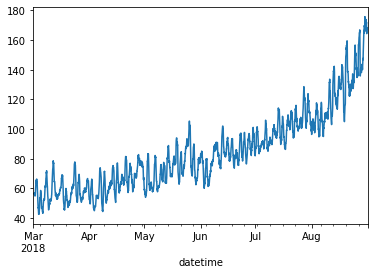

In [32]:
decomposed.trend.plot();

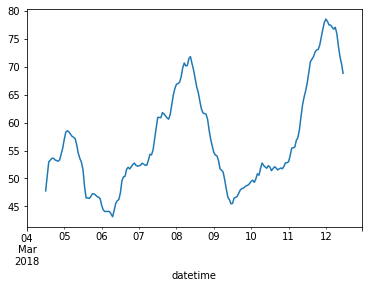

In [33]:
decomposedWeek.trend.plot();

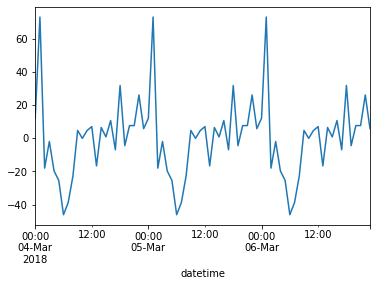

In [34]:
decomposedFewDays.seasonal.plot();

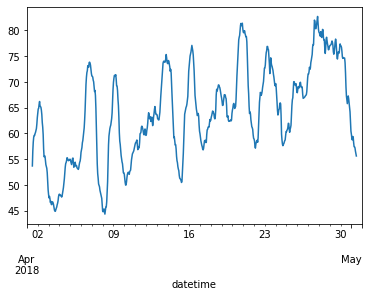

In [35]:
decomposedMonth_apr.trend.plot();

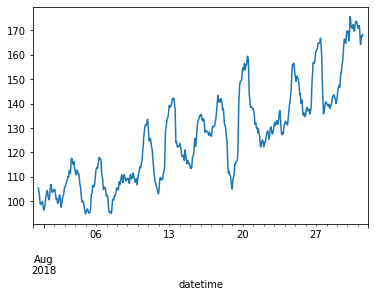

In [36]:
decomposedMonth_aug.trend.plot();

# Вывод:

1)в летний период количество заказов растет (вероятно из-за жары люди предпочитают лишний раз проехаться в такси с кондиционером, чем душный общественный транспорт);

2)отметили тенденцию слабого спроса во вторник,субботу и воскресенье. Возможно, это связано с тем, что в весенне-летний период многие за городом, такси им не нужно, также кто-то отдыхает дома от рабочих будней;

3)что касается популярного для такси времени можно отметить,что рано утром самые плохие показатели, ситуация начинает улучшаться только после 6 утра и ближе к 12 приходит стандартное положение с небольшими колебаниями,ближе к полуночи заметно резкое увеличение спроса на такси (вероятно, люди возвращаются с вечерних посиделок плюс те, кто поздно заканчивают работу).


## Обучение

3.1. Создадим признаки для обучения моделей

In [115]:
def make_features(data_taxi, max_lag, rolling_sum_size):
    data_taxi['dayofweek'] = data_taxi.index.dayofweek
    data_taxi['hour'] = data_taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        data_taxi['lag_{}'.format(lag)] = data_taxi['num_orders'].shift(lag)
   
    data_taxi['rolling_sum'] = data_taxi['num_orders'].shift().rolling(rolling_sum_size).mean()

In [116]:
make_features(data_taxi, 20 , 6)

3.2. Выделим тренировочную и тестовую выборки, признаки

In [42]:
train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

3.3. Обучим модели

Linear Regression

In [104]:
features= data_taxi.drop('num_orders', axis = 1)
target = data_taxi['num_orders']


#разделяю данные на обучающую(80%) и валидационную+тестовую(в совокупности 20%) выборки:
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target, shuffle=False, test_size=0.2,
                                                                              random_state=12345)

#разделим валидационную и тестовую выборки(делим предыдущий результат пополам):
features_test, features_valid, target_test, target_valid = train_test_split(features_valid,
                                                                            target_valid,shuffle=False, test_size=0.5,
                                                                            random_state=12345)




In [108]:
%%time
modelLR = LinearRegression()
modelLR.fit(train_features, train_target)

CPU times: user 22.4 ms, sys: 19.2 ms, total: 41.5 ms
Wall time: 14 ms


LinearRegression()

In [109]:
%%time
predictionLR = modelLR.predict(features_valid)
mean_squared_error(target_valid,predictionLR)**0.5

CPU times: user 10.4 ms, sys: 45.6 ms, total: 56 ms
Wall time: 11.6 ms


45.810948889069465

CatBoost

In [47]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)
modelCat = CatBoostRegressor( random_state = 12345)

In [48]:
%%time
param_search = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'iterations' : [1000, 2000],
                'verbose' : [False]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchCat = GridSearchCV(estimator=modelCat, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchCat.fit(train_features, train_target)

CPU times: user 23min 36s, sys: 10.6 s, total: 23min 47s
Wall time: 25min 34s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f66407880d0>,
             param_grid={'depth': [3, 6, 10], 'iterations': [1000, 2000],
                         'learning_rate': [0.03, 0.1], 'verbose': [False]},
             scoring='neg_root_mean_squared_error')

In [113]:
%%time
predictionCBR = gsearchCat.best_estimator_.predict(features_train)
mean_squared_error(target_train,predictionCBR)**0.5

CPU times: user 11.1 ms, sys: 61 µs, total: 11.2 ms
Wall time: 9.64 ms


10.008175670580629

In [51]:
np.abs(gsearchCat.best_score_)

24.07001586075415

In [52]:
gsearchCat.best_params_

{'depth': 6, 'iterations': 2000, 'learning_rate': 0.03, 'verbose': False}

LightGBM

In [57]:
%%time
modelLight = LGBMRegressor(random_state = 42)
param_search = {'max_depth' : [-1,3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [100,200,1000]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchLight = GridSearchCV(estimator=modelLight, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchLight.fit(train_features, train_target)

CPU times: user 4min 55s, sys: 7.32 s, total: 5min 3s
Wall time: 5min 5s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': [0.03, 0.1],
                         'max_depth': [-1, 3, 6, 10],
                         'n_estimators': [100, 200, 1000]},
             scoring='neg_root_mean_squared_error')

In [58]:
np.abs(gsearchLight.best_score_)

24.569283505252514

In [59]:
gsearchLight.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [114]:
%%time
predictionLGBM = gsearchLight.best_estimator_.predict(features_train)
mean_squared_error(target_train,predictionLGBM)**0.5

CPU times: user 64.6 ms, sys: 0 ns, total: 64.6 ms
Wall time: 12.6 ms


17.449930796644818

# Вывод:

Мы выявили лучшие параметры и обучили 3 модели: Linear Regression, CatBoost, LightGBM.

Быстрее всего обучается Linear Regression, дольше всего - CatBoost.

Лучший RMSE у CatBoost, чуть хуже - у LightGBM.


Заказчику предложим LightGBM в связи с тем, что RMSE у нее чуть хуже, чем у CatBoost, но <48, что соответствует условиям задачи, а время обучения CatBoost значительно больше.


## Тестирование

Протестируем наши модели на тестовой выборке с лучшими параметрами


Linear Regression

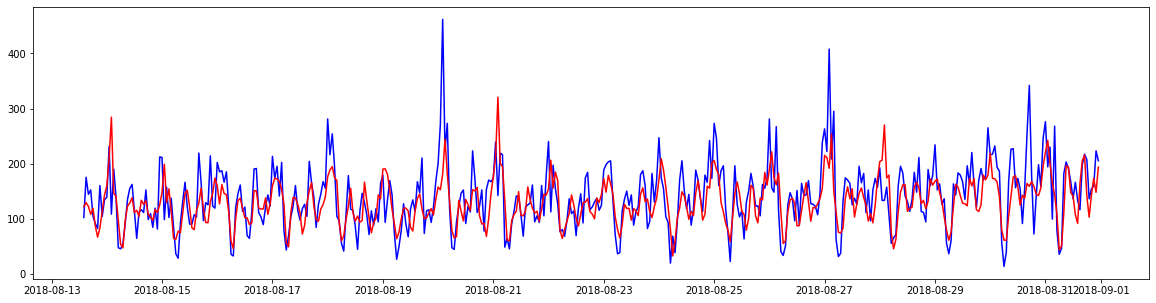

In [75]:
model = LinearRegression()
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=(20,5))
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

CatBoost

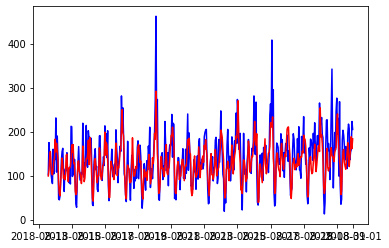

In [63]:
model = CatBoostRegressor(learning_rate=0.03,
                          depth=6,
                          iterations=2000,
                          random_state=1515, 
                          verbose=False) 
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_CBR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure()
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')


LightGBM

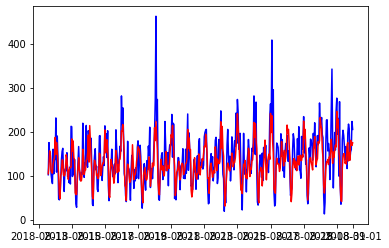

In [65]:
model = LGBMRegressor(learning_rate=0.1,
                          max_depth=3,
                          n_estimators=200,
                          random_state=1515, 
                          ) 
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LGBM = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure()
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')


Вывыедем RMSE наших моделей на тестовой выборке

In [71]:
print(f"Linear Regression {final_RMSE_LR}")
print(f"CatBoost {final_RMSE_CBR}")
print(f"LightGBM {final_RMSE_LGBM}")

Linear Regression 45.810948889069465
CatBoost 39.82403147662771
LightGBM 40.13333343986014


# Вывод:
1. на тестовой выборке у всех моделей RMSE<48, что соответствует условиям задачи;
2. лучший RMSE на тестовой выборке у CatBoost, чуть хуже - у LightGBM;
3. из графиков видно, что предсказания и реальность близки.

# Общий вывод:

Для выполнения поставленной задачи построить модель, способную прогнозировать количество заказов такси на следующий час, мы изучили исторические данные по заказам такси, произвели, предобработку.

Затем изучили и проанализировали сезонность и тренды, выявили, что летом, а также в конце каждого месяца количество заказов растет, в выходные заказов меньше, ранним утром заказов мало, большой спрос на такси ближе к полуночи.

Также мы выявили лучшие параметры и обучили 3 модели: Linear Regression, CatBoost, LightGBM.
Быстрее всего обучается Linear Regression, дольше всего - CatBoost.
Проверили модели на тестовой выборке. Выявили, что лучший RMSE у CatBoost, чуть хуже - у LightGBM.

Заказчику предложим LightGBM в связи с тем, что RMSE у нее чуть хуже, чем у CatBoost, но <48, что соответствует условиям задачи, а время обучения CatBoost значительно больше.
